In [1]:
from mesa import Agent
from mesa import Model
import numpy as np
from matplotlib import pyplot as plt
from mesa.space import MultiGrid

Agents

In [2]:
class Spice(Agent):
    """
    Spice:
    - contains an amount of spice
    - grows 1 amount of spice at each turn
    """

    def __init__(self):
        print("I'm a Spice agent")


class Sugar(Agent):
    """
    Sugar agent:
    - contains an amount of sugar
    - grows 1 amount of sugar at each turn
    """

    def __init__(self):
        print("I'm a Sugar agent")


class Trader(Agent):
    """
    Trader agent:
    - has a metabolism for sugar and spice
    - harvest and traders sugar and spice to survive and thrive
    """

    def __init__(self):
        print("I'm a Trader")

Model

In [13]:
class MyModel(Model):
    """
    A model class to manage Sugarspace with Traders
    """
    def __init__(self, width=50, height=50):
        super().__init__()
        print("Its a model")
        self.width = width
        self.height = height
        self.grid = MultiGrid(width, height, torus=False)

        sugar_distribution = np.genfromtxt('sugar-map.txt')
        spice_distribution = np.flip(sugar_distribution, axis=1)
        print(sugar_distribution.shape)
        plt.imshow(sugar_distribution, origin='lower')
        # plt.imshow(spice_distribution, origin='lower')

        self.sugar = Sugar()
        self.spice = Spice()
        self.trader = Trader()

Its a model
(50, 50)
I'm a Sugar agent
I'm a Spice agent
I'm a Trader


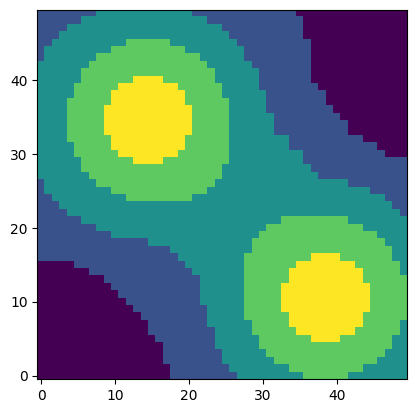

In [14]:
model = MyModel()